# Atmospheric, oceanic and land data handling

In this notebook we discuss the subtleties of how NetCDF-SCM handles different data 'realms' and why these choices are made. The realms of intereset to date are atmosphere, ocean and land and the distinction between the realms follows the [CMIP6 realm controlled vocabulary](https://github.com/WCRP-CMIP/CMIP6_CVs/blob/master/CMIP6_realm.json).

TODO: make this notebook follow something like the following outline

1. Oceanic data handling
    - choices
        - areacello and stfof weighted means
        - assume everything is ocean (i.e. all land weights are zero)
    - why
        - there is no land box relevant data in ocean output
        - area as otherwise your output is nonsense
        - sftof so you're not overweighting cells which aren't really representative of the ocean
        - show plots to show difference made by these choices
1. Land data handling
    - choices
        - areacella and stflf weighted means
        - assume everything is land (i.e. all ocean weights are zero)
    - why
        - there is no ocean box relevant data in land output
        - area as otherwise your output is nonsense
        - sftlf so you're not overweighting cells which aren't really representative of the land
        - show plots to show difference made by these choices
1. Atmospheric data handling
    - choices
        - areacella weighted means
            - land box means are further weighted by sftlf
            - ocean box means are further weighted by (100 - sftlf)
    - why
        - contribution of data to SCM boxes depends on land fraction
        - area as otherwise your output is nonsense
        - sftlf so you split land/ocean data appropriately
        - show plots to show difference made by these choices

In [1]:
from os.path import join

import expectexception
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

from netcdf_scm.iris_cube_wrappers import CMIP6OutputCube
from netcdf_scm.utils import broadcast_onto_lat_lon_grid

<IPython.core.display.Javascript object>

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use("bmh")

In [3]:
import logging
root_logger = logging.getLogger()
root_logger.setLevel(logging.WARNING)
root_logger.addHandler(logging.StreamHandler())

In [4]:
DATA_PATH_TEST = join("..", "tests", "test-data")

Note that all of our data is on a regular grid, data on native model grids does not plot as nicely.

In [5]:
tas_file = join(
    DATA_PATH_TEST,
    "cmip6output",
    "CMIP6",
    "CMIP",
    "NCAR",
    "CESM2",
    "historical",
    "r7i1p1f1",
    "Amon",
    "tas",
    "gn",
    "v20190311",
    "tas_Amon_CESM2_historical_r7i1p1f1_gn_195701-195703.nc"
)

gpp_file = tas_file.replace(
    "Amon", "Lmon"
).replace(
    "tas", "gpp"
)

csoilfast_file = gpp_file.replace("gpp", "cSoilFast")

hfds_file = tas_file.replace(
    "Amon", "Omon"
).replace("tas", "hfds")

## Oceans

We start by loading our data.




In [6]:
hfds = CMIP6OutputCube()
hfds.load_data_from_path(hfds_file)

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


NetCDF-SCM will assume whether the data is "ocean", "land" or "atmosphere". The assumed realm can be checked by examining a `SCMCube`'s `netcdf_scm_realm` property. 

In our case we have "ocean" data.

In [7]:
hfds.netcdf_scm_realm

'ocean'

If we have ocean data, then there is no data which will go in a "land" box. Hence, if we request e.g. `World|Land` data, an error will be raised.

In [8]:
# hfds.get_scm_timeseries_weights()

In [9]:
# print(hfds.cube)

In [10]:
# hfds.get_scm_timeseries(regions=["World", "World|Land"])

In [11]:
# %%expect_exception ValueError

# hfds.get_scm_timeseries(regions=["World", "World|Land"])

When taking averages, there are 3 obvious options:

- unweighted average
- area weighted average
- area and surface fraction weighted average

In NetCDF-SCM, we always go for the third type in order to make sure that our weights are both area weighted and take into account how much each cell represents the SCM box of interest.

In the cells below, we show the difference this choice makes.

In [12]:
hfds_unweighted_mean = hfds.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN
)

Collapsing spatial coordinate 'latitude' without weighting
cannot be safely cast to variable data type
Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.


We can always check which variable is being used for the cell areas by lo

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


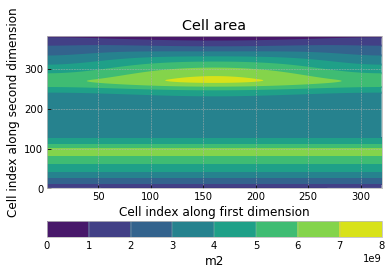

In [13]:
hfds_area_cell = hfds.get_metadata_cube(hfds.areacell_var).cube

qplt.contourf(
    hfds_area_cell,
);

In [14]:
area_weights = broadcast_onto_lat_lon_grid(
    hfds, 
    hfds_area_cell.data
)
hfds_area_weighted_mean= hfds.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=area_weights
)

cannot be safely cast to variable data type


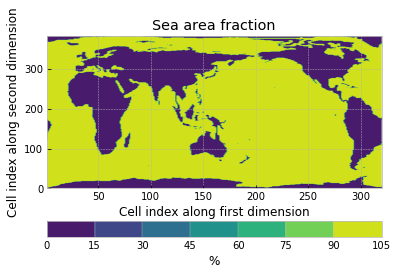

In [15]:
hfds_surface_frac = hfds.get_metadata_cube(hfds.surface_fraction_var).cube

qplt.contourf(
    hfds_surface_frac,
);

CoordinateMultiDimError: Cannot apply constraints to multidimensional coordinates

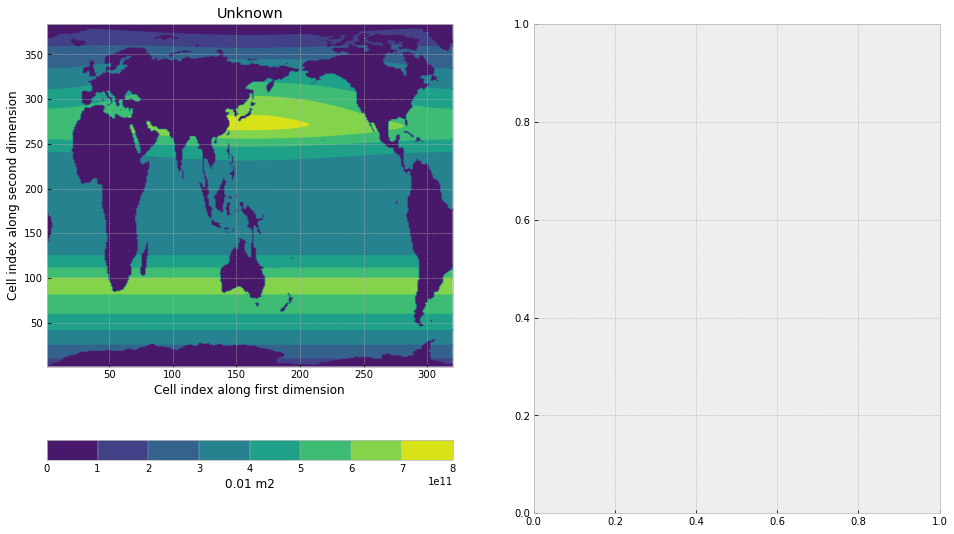

In [16]:
hfds_area_sf = hfds_area_cell * hfds_surface_frac

plt.figure(figsize=(16, 9))
plt.subplot(121)
qplt.contourf(
    hfds_area_sf,
)

plt.subplot(122)
lat_con = iris.Constraint(latitude=lambda cell: -45 < cell < -20)
lon_con = iris.Constraint(longitude=lambda cell: 140 < cell < 160)
qplt.contourf(
    hfds_area_sf.extract(lat_con & lon_con),
)

In [17]:
hfds_area_sf_weights = broadcast_onto_lat_lon_grid(
    hfds, 
    hfds_area_sf.data
)
hfds_area_sftlf_weighted_mean = hfds.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=hfds_area_sf_weights
)

Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.


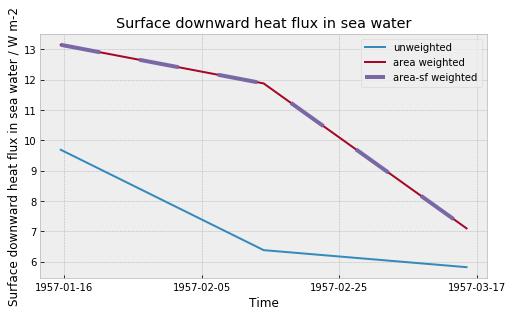

In [18]:
plt.figure(figsize=(8, 4.5))
qplt.plot(hfds_unweighted_mean, label="unweighted")
qplt.plot(hfds_area_weighted_mean, label="area weighted")
qplt.plot(
    hfds_area_sftlf_weighted_mean, 
    label="area-sf weighted", 
    linestyle="--",
    dashes=(10, 10),
    linewidth=4
)

plt.legend();

1. Load data
1. Discuss no land box error
1. Show weighting, compare to other options

1. Oceanic data handling
    - choices
        - areacello and stfof weighted means
        - assume everything is ocean (i.e. all land weights are zero)
    - why
        - there is no land box relevant data in ocean output
        - area as otherwise your output is nonsense
        - sftof so you're not overweighting cells which aren't really representative of the ocean
        - show plots to show difference made by these choices

----